In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

from lcs.metrics import population_metrics
from lcs.agents import EnvironmentAdapter
from lcs import Perception
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.strategies.action_selection2 import EpsilonGreedy, ActionDelay, KnowledgeArray

import math
from time import sleep
from copy import copy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load environments
import gym

# Load utils
from utils.postprocessing import parse_experiments_results

%matplotlib inline

In [2]:
EXPERIMENTS = 5
EXPLORE_TRIALS = 500
EXPLOIT_TRIALS = 500

In [3]:
env = gym.make('CartPole-v0')

In [4]:
# https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947

_high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
_low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]

# buckets = (1, 1, 10, 14)  # A: seems to be ok
# buckets = (2, 2, 2, 4)  # B
buckets = (1, 1, 3, 6)  # C

In [5]:
def cp_metrics(pop, env):
    metrics = {}
    metrics.update(population_metrics(pop, env))
    
    return metrics

class CartPoleAdapter(EnvironmentAdapter):
    @classmethod
    def to_genotype(cls, obs):
        ratios = [(obs[i] + abs(_low[i])) / (_high[i] - _low[i]) for i in range(len(obs))]
        new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return [str(o) for o in new_obs]
    
# CartPoleAdapter.to_genotype([0, 0, 0, 0])

In [6]:
base_params = {
    "action_selector": EpsilonGreedy,
    "epsilon": 0.9,
    "beta": 0.01,
    "gamma": 0.99,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "mu": 0.03,
    "chi": 0.0,  # we don't want cross-over
    "metrics_trial_frequency": 5,
    "environment_adapter": CartPoleAdapter,
    "user_metrics_collector_fcn": cp_metrics
}

In [7]:
def print_cl(cl):
    actions = ['L', 'R']
    action = actions[cl.action]
    
    marked = ''
    
    if cl.is_marked():
        marked = '(*)'
    
    return (f"{cl.condition} - {action} - {cl.effect} [q: {cl.q:.3f}, fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f}] {marked}")

In [8]:
def start_single_experiment(**kwargs):
    # Prepare the environment
    env.reset()

    cfg = Configuration(4, 2, **kwargs)
    sleep(1)
    
    explorer = ACS2(cfg)
    population_explore, metrics_explore = explorer.explore(env, EXPLORE_TRIALS, decay=False)
    
    exploiter = ACS2(cfg, population_explore)
    population_exploit, metrics_exploit = explorer.exploit(env, EXPLOIT_TRIALS)
    
    # Parse results into DataFrame
    df = parse_experiments_results(metrics_explore, metrics_exploit, cfg.metrics_trial_frequency)
    
    return population_exploit, df

In [9]:
def avg_experiments(n, **kwargs):
    dfs = []
    print(f"{kwargs}\n")

    for i in range(n):
        print(f"Executing experiment {i}")
        _, df = start_single_experiment(**kwargs)
        dfs.append(df)
    
    bar = pd.concat(dfs)
    perf_df = bar.groupby(['trial', 'phase']).mean().reset_index(level='phase')

    return perf_df

## Baseline (epsilon greedy)

In [10]:
# Prepare parameters
epsilon_greedy_params = copy(base_params)

epsilon_greedy_df = avg_experiments(EXPERIMENTS, **epsilon_greedy_params)

{'action_selector': <class 'lcs.strategies.action_selection2.EpsilonGreedy.EpsilonGreedy'>, 'epsilon': 0.9, 'beta': 0.01, 'gamma': 0.99, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'chi': 0.0, 'metrics_trial_frequency': 5, 'environment_adapter': <class '__main__.CartPoleAdapter'>, 'user_metrics_collector_fcn': <function cp_metrics at 0x11772cef0>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4


## Action Delay Bias

In [11]:
action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = avg_experiments(EXPERIMENTS, **action_delay_params)

{'action_selector': <class 'lcs.strategies.action_selection2.ActionDelay.ActionDelay'>, 'epsilon': 0.9, 'beta': 0.01, 'gamma': 0.99, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'chi': 0.0, 'metrics_trial_frequency': 5, 'environment_adapter': <class '__main__.CartPoleAdapter'>, 'user_metrics_collector_fcn': <function cp_metrics at 0x11772cef0>, 'biased_exploration_prob': 0.5}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4


## Knowledge Array Bias

In [12]:
knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = avg_experiments(EXPERIMENTS, **knowledge_array_params)

{'action_selector': <class 'lcs.strategies.action_selection2.KnowledgeArray.KnowledgeArray'>, 'epsilon': 0.9, 'beta': 0.01, 'gamma': 0.99, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'chi': 0.0, 'metrics_trial_frequency': 5, 'environment_adapter': <class '__main__.CartPoleAdapter'>, 'user_metrics_collector_fcn': <function cp_metrics at 0x11772cef0>, 'biased_exploration_prob': 0.5}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4


## Optimistic initial quality values

In [13]:
op_initial_params = copy(base_params)
op_initial_params['initial_q'] = 0.8

op_initial_df = avg_experiments(EXPERIMENTS, **op_initial_params)

{'action_selector': <class 'lcs.strategies.action_selection2.EpsilonGreedy.EpsilonGreedy'>, 'epsilon': 0.9, 'beta': 0.01, 'gamma': 0.99, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'chi': 0.0, 'metrics_trial_frequency': 5, 'environment_adapter': <class '__main__.CartPoleAdapter'>, 'user_metrics_collector_fcn': <function cp_metrics at 0x11772cef0>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4


# Visualization

## Steps

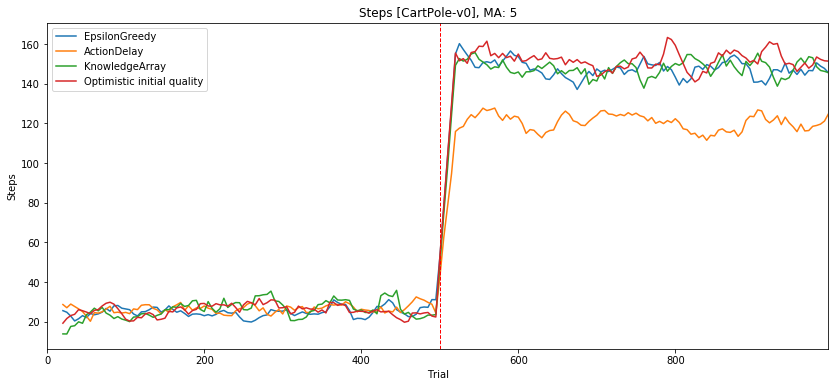

In [14]:
window = 5

fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['steps_in_trial'].rolling(window=window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['steps_in_trial'].rolling(window=window).mean().plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['steps_in_trial'].rolling(window=window).mean().plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['steps_in_trial'].rolling(window=window).mean().plot(label='Optimistic initial quality', ax=ax)

ax.axvline(x=EXPLORE_TRIALS, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('Steps')
ax.set_title(f'Steps [{env.unwrapped.spec.id}], MA: {window}')
ax.legend()

plt.show()

## Population (reliable classifiers)

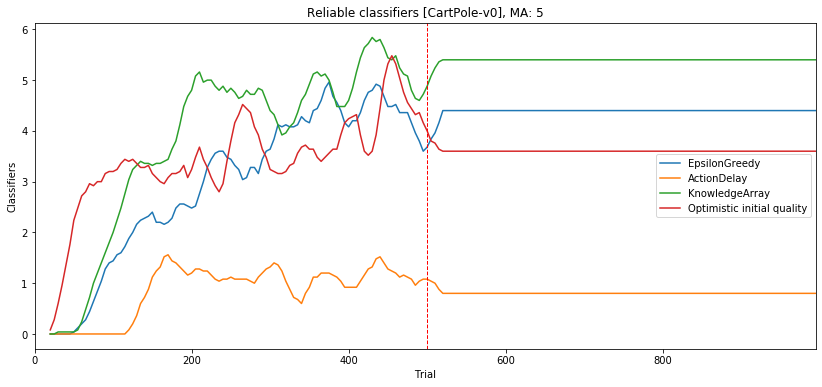

In [15]:
window = 5
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['reliable'].rolling(window=window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['reliable'].rolling(window=window).mean().plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['reliable'].rolling(window=window).mean().plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['reliable'].rolling(window=window).mean().plot(label='Optimistic initial quality', ax=ax)

ax.axvline(x=EXPLORE_TRIALS, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('Classifiers')
ax.set_title(f'Reliable classifiers [{env.unwrapped.spec.id}], MA: {window}')
ax.legend()

plt.show()